Install Packages

In [ ]:
!pip install torch torchvision matplotlib numpy tqdm tensorboard

Setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


Data Loading and Preprocessing

100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


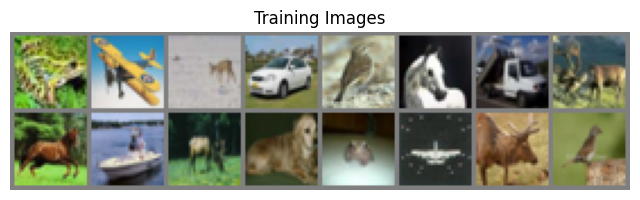

In [3]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Scale to [-1, 1]
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Visualize some training images
def show_images(images, title=""):
    images = images / 2 + 0.5  # Unnormalize
    np_images = images.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(np_images, (1, 2, 0)))      # I have a friend that's a superstar, Nicole!... incredible voice, yoh!
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training data
data_iter = iter(train_loader)
images, _ = next(data_iter)
show_images(make_grid(images[:16]), "Training Images")

Define the Noise Schedule (Variance-Preserving SDE)

In [4]:
class VPSDE:
    def __init__(self, beta_min=0.1, beta_max=20, T=1.0):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T

    def beta(self, t):
        return self.beta_min + t*(self.beta_max - self.beta_min)

    def marginal_prob(self, x, t):
        log_mean_coeff = -0.25 * t**2 * (self.beta_max - self.beta_min) - 0.5 * t * self.beta_min
        mean = torch.exp(log_mean_coeff[:, None, None, None]) * x
        std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
        return mean, std

    def drift(self, x, t):
        beta_t = self.beta(t)
        return -0.5 * beta_t[:, None, None, None] * x

    def diffusion(self, t):
        beta_t = self.beta(t)
        return torch.sqrt(beta_t)

# Create the SDE
sde = VPSDE()

Define the Score Network (U-Net Architecture)

In [5]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        half_dim = dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float) * -emb)
        self.register_buffer('emb', emb)

    def forward(self, t):
        emb = t[:, None] * self.emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # First convolution
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second convolution
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class UNet(nn.Module):
    def __init__(self, in_channels=3, hidden_dims=[64, 128, 256, 512]):
        super().__init__()
        time_emb_dim = 32
        self.time_mlp = TimeEmbedding(time_emb_dim)

        # Initial projection
        self.conv0 = nn.Conv2d(in_channels, hidden_dims[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([
            Block(hidden_dims[i], hidden_dims[i+1], time_emb_dim)
            for i in range(len(hidden_dims)-1)
        ])

        # Upsample
        self.ups = nn.ModuleList([
            Block(hidden_dims[i], hidden_dims[i-1], time_emb_dim, up=True)
            for i in range(len(hidden_dims)-1, 0, -1)
        ])

        # Final layers
        self.final = nn.Conv2d(hidden_dims[0], in_channels, 3, padding=1)

    def forward(self, x, t):
        # Embed time
        t = self.time_mlp(t)

        # Initial conv
        x = self.conv0(x)

        # Unet
        h = []
        for i, down in enumerate(self.downs):
            x = down(x, t)
            h.append(x)

        for i, up in enumerate(self.ups):
            x = up(torch.cat([x, h.pop()], dim=1), t)

        return self.final(x)

# Create the score network
score_model = UNet().to(device)
print(f"Number of parameters: {sum(p.numel() for p in score_model.parameters()):,}")

Number of parameters: 15,454,147


Define the Training Loss (Score Matching)

In [7]:
def loss_fn(model, x, sde):
    # Random time points
    t = torch.rand(x.shape[0], device=device) * (sde.T - 1e-3) + 1e-3

    # Compute mean and std of the perturbation kern
    mean, std = sde.marginal_prob(x, t)

    # Sample noise
    z = torch.randn_like(x)

    # Perturb the data
    perturbed_x = mean + std[:, None, None, None] * z

    # Predict the score
    score = model(perturbed_x, t)

    # Compute the loss (Fisher divergence)
    losses = torch.square(score * std[:, None, None, None] + z)
    return torch.mean(losses)

Training Loop

Epoch 1: 100%|██████████| 391/391 [01:13<00:00,  5.35it/s, loss=0.15]


Epoch 1, Average Loss: 0.2627


Epoch 2: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.0834]


Epoch 2, Average Loss: 0.0974


Epoch 3: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.0596]


Epoch 3, Average Loss: 0.0789


Epoch 4: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.0653]


Epoch 4, Average Loss: 0.0746


Epoch 5: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0787]


Epoch 5, Average Loss: 0.0674


Epoch 6: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0576]


Epoch 6, Average Loss: 0.0658


Epoch 7: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.0465]


Epoch 7, Average Loss: 0.0635


Epoch 8: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0531]


Epoch 8, Average Loss: 0.0594


Epoch 9: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0392]


Epoch 9, Average Loss: 0.0608


Epoch 10: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.101]


Epoch 10, Average Loss: 0.0583


Epoch 11: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.0742]


Epoch 11, Average Loss: 0.0561


Epoch 12: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0548]


Epoch 12, Average Loss: 0.0548


Epoch 13: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0518]


Epoch 13, Average Loss: 0.0539


Epoch 14: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0452]


Epoch 14, Average Loss: 0.0533


Epoch 15: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0505]


Epoch 15, Average Loss: 0.0529


Epoch 16: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.083]


Epoch 16, Average Loss: 0.0512


Epoch 17: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0591]


Epoch 17, Average Loss: 0.0536


Epoch 18: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0687]


Epoch 18, Average Loss: 0.0522


Epoch 19: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0701]


Epoch 19, Average Loss: 0.0506


Epoch 20: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0455]


Epoch 20, Average Loss: 0.0500


Epoch 21: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.0494]


Epoch 21, Average Loss: 0.0485


Epoch 22: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0449]


Epoch 22, Average Loss: 0.0498


Epoch 23: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.0374]


Epoch 23, Average Loss: 0.0488


Epoch 24: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0425]


Epoch 24, Average Loss: 0.0479


Epoch 25: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0388]


Epoch 25, Average Loss: 0.0465


Epoch 26: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0622]


Epoch 26, Average Loss: 0.0474


Epoch 27: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0351]


Epoch 27, Average Loss: 0.0481


Epoch 28: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0448]


Epoch 28, Average Loss: 0.0465


Epoch 29: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.0467]


Epoch 29, Average Loss: 0.0460


Epoch 30: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0431]


Epoch 30, Average Loss: 0.0456


Epoch 31: 100%|██████████| 391/391 [01:14<00:00,  5.28it/s, loss=0.0344]


Epoch 31, Average Loss: 0.0459


Epoch 32: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.0386]


Epoch 32, Average Loss: 0.0453


Epoch 33: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=0.0462]


Epoch 33, Average Loss: 0.0452


Epoch 34: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.076]


Epoch 34, Average Loss: 0.0525


Epoch 35: 100%|██████████| 391/391 [01:14<00:00,  5.28it/s, loss=0.0438]


Epoch 35, Average Loss: 0.0484


Epoch 36: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0518]


Epoch 36, Average Loss: 0.0461


Epoch 37: 100%|██████████| 391/391 [01:13<00:00,  5.32it/s, loss=0.0322]


Epoch 37, Average Loss: 0.0452


Epoch 38: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0395]


Epoch 38, Average Loss: 0.0461


Epoch 39: 100%|██████████| 391/391 [01:13<00:00,  5.33it/s, loss=0.0405]


Epoch 39, Average Loss: 0.0445


Epoch 40: 100%|██████████| 391/391 [01:13<00:00,  5.32it/s, loss=0.0498]


Epoch 40, Average Loss: 0.0436


Epoch 41: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0364]


Epoch 41, Average Loss: 0.0438


Epoch 42: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0475]


Epoch 42, Average Loss: 0.0435


Epoch 43: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0621]


Epoch 43, Average Loss: 0.0436


Epoch 44: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, loss=0.0391]


Epoch 44, Average Loss: 0.0427


Epoch 45: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0364]


Epoch 45, Average Loss: 0.0438


Epoch 46: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0431]


Epoch 46, Average Loss: 0.0427


Epoch 47: 100%|██████████| 391/391 [01:13<00:00,  5.32it/s, loss=0.0307]


Epoch 47, Average Loss: 0.0427


Epoch 48: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0354]


Epoch 48, Average Loss: 0.0431


Epoch 49: 100%|██████████| 391/391 [01:13<00:00,  5.31it/s, loss=0.0474]


Epoch 49, Average Loss: 0.0422


Epoch 50: 100%|██████████| 391/391 [01:13<00:00,  5.32it/s, loss=0.0473]


Epoch 50, Average Loss: 0.0412


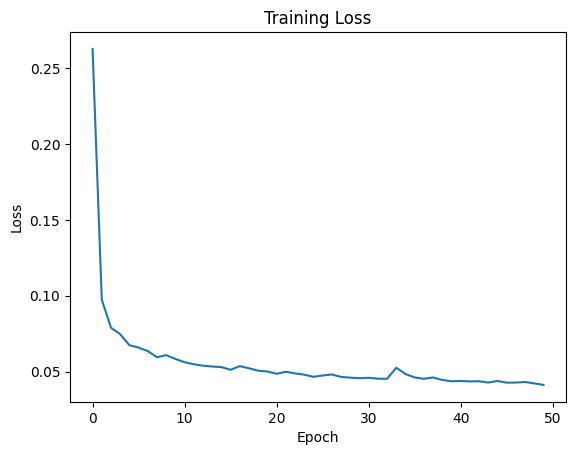

In [8]:
# Training parameters
epochs = 50
lr = 1e-4

# Optimizer
optimizer = optim.Adam(score_model.parameters(), lr=lr)

# Training loop
def train(epoch):
    score_model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")

    for x, _ in pbar:
        x = x.to(device)

        optimizer.zero_grad()
        loss = loss_fn(score_model, x, sde)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")         # sh*t man, this took forever!
    return avg_loss

# Train the model
train_losses = []
for epoch in range(1, epochs + 1):
    train_losses.append(train(epoch))

# Plot training loss
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

Sampling with Langevin Dynamics (Predictor-Corrector)

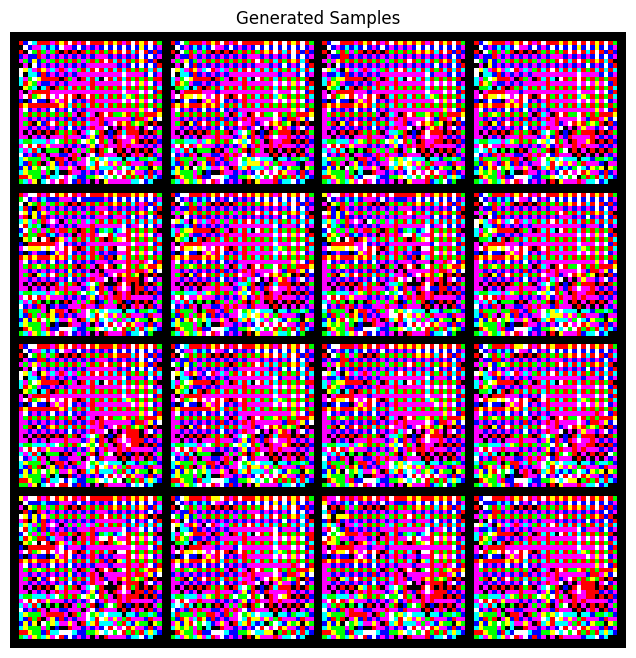

In [9]:
def pc_sampler(model, sde, batch_size=64, num_steps=1000, snr=0.16, eps=1e-3):
    """Predictor-Corrector (PC) sampler.

    Args:
        model: The score model.
        sde: The SDE defining the diffusion process.
        batch_size: Number of samples to generate.
        num_steps: Number of discretization steps.
        snr: Signal-to-noise ratio for the corrector step.
        eps: Smallest time step to avoid numerical issues.
        Slow Down...
    """
    model.eval()
    with torch.no_grad():
        # Initial sample (noise)
        x = torch.randn(batch_size, 3, 32, 32, device=device)

        # Time steps
        time_steps = torch.linspace(sde.T, eps, num_steps, device=device)
        step_size = time_steps[0] - time_steps[1]

        for t in time_steps:
            # Create a batch of time steps
            batch_time_step = torch.ones(batch_size, device=device) * t

            # Predictor step (Euler-Maruyama)
            drift = sde.drift(x, batch_time_step)
            diffusion = sde.diffusion(batch_time_step)
            score = model(x, batch_time_step)

            # Update x with predictor step
            x_mean = x + (drift - diffusion[:, None, None, None]**2 * score) * step_size
            noise = torch.randn_like(x)
            x = x_mean + diffusion[:, None, None, None] * torch.sqrt(step_size) * noise

            # Corrector step (Langevin MCMC)
            grad = score
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

        return x_mean

# Generate samples
samples = pc_sampler(score_model, sde, batch_size=16)

# Visualize generated samples
def show_samples(samples, title=""):
    samples = samples.cpu() / 2 + 0.5  # Unnormalize
    grid = make_grid(samples, nrow=4)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

show_samples(samples, "Generated Samples")

Evaluation (Negative Log-Likelihood Estimation)

In [10]:
def estimate_nll(model, sde, data_loader, num_samples=100):
    """Estimate negative log-likelihood using importance sampling."""
    model.eval()
    total_nll = 0
    count = 0

    with torch.no_grad():
        for x, _ in tqdm(data_loader):
            x = x.to(device)
            batch_size = x.shape[0]

            # Compute the score for each data point
            t = torch.ones(batch_size, device=device) * sde.T
            score = model(x, t)

            # Compute the energy (unnormalized log probability)
            energy = -0.5 * torch.sum(score**2, dim=[1, 2, 3])

            # Importance sampling to estimate the partition function
            log_z = 0
            for _ in range(num_samples):
                z = torch.randn_like(x)
                t_z = torch.ones(z.shape[0], device=device) * sde.T
                score_z = model(z, t_z)
                energy_z = -0.5 * torch.sum(score_z**2, dim=[1, 2, 3])
                log_z += torch.logsumexp(energy_z, dim=0) - math.log(num_samples)

            # Compute NLL
            nll = -energy + log_z
            total_nll += nll.sum().item()
            count += batch_size

    return total_nll / count

# Estimate NLL on test set
nll = estimate_nll(score_model, sde, test_loader, num_samples=100)
print(f"Estimated Negative Log-Likelihood: {nll:.4f} nats/dim")

100%|██████████| 79/79 [07:18<00:00,  5.55s/it]

Estimated Negative Log-Likelihood: -147107.0045 nats/dim


Diffusion Process Analysis

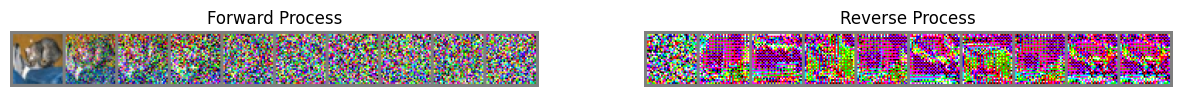

In [15]:
def analyze_diffusion(model, sde, x0):
    """Analyze the diffusion process for a given input."""
    x0 = x0.to(device).unsqueeze(0)
    num_steps = 10
    time_steps = torch.linspace(0, sde.T, num_steps, device=device)

    # Forward process
    forward_samples = []
    for t in time_steps:
        mean, std = sde.marginal_prob(x0, t.unsqueeze(0))
        z = torch.randn_like(x0)
        perturbed_x = mean + std * z
        forward_samples.append(perturbed_x.squeeze().cpu())

    # Reverse process
    reverse_samples = []
    x = torch.randn_like(x0)
    reverse_time_steps = torch.linspace(sde.T, 0, num_steps, device=device)
    for t in reverse_time_steps:
        batch_time_step = torch.ones(1, device=device) * t
        score = model(x, batch_time_step)
        drift = sde.drift(x, batch_time_step)
        diffusion = sde.diffusion(batch_time_step)

        if t > 0:
            step_size = reverse_time_steps[0] - reverse_time_steps[1]
            x_mean = x + (drift - diffusion**2 * score) * step_size
            noise = torch.randn_like(x)
            x = x_mean + diffusion * torch.sqrt(step_size) * noise
        else:
            x = x + (drift - diffusion**2 * score) * 1e-3

        reverse_samples.append(x.squeeze().cpu())

    # Plot
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.title("Forward Process")
    grid = make_grid(forward_samples, nrow=num_steps)
    plt.imshow(grid.permute(1, 2, 0) / 2 + 0.5)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Reverse Process")
    grid = make_grid(reverse_samples, nrow=num_steps)
    plt.imshow(grid.permute(1, 2, 0) / 2 + 0.5)
    plt.axis('off')

    plt.show()

# test image
test_iter = iter(test_loader)
test_image, _ = next(test_iter)
analyze_diffusion(score_model, sde, test_image[0])

Stability Analysis of Denoising Dynamics

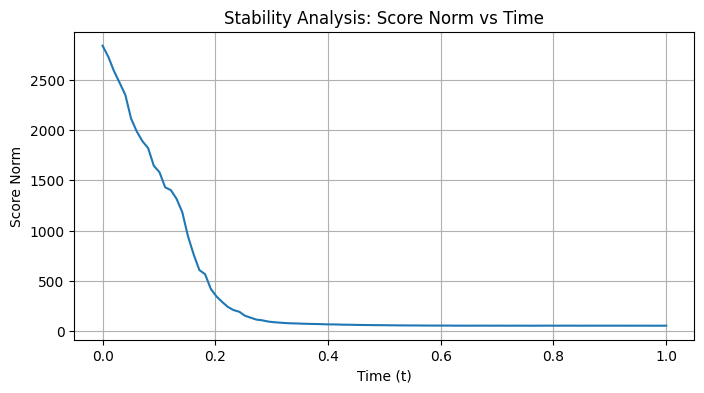

In [12]:
def stability_analysis(model, sde):
    """Analyze the stability of the denoising dynamics."""
    num_points = 100
    t_values = torch.linspace(0, sde.T, num_points, device=device)

    # Track norm of the score function for random inputs
    score_norms = []
    for t in t_values:
        x = torch.randn(10, 3, 32, 32, device=device)
        batch_time_step = torch.ones(x.shape[0], device=device) * t
        score = model(x, batch_time_step)
        score_norm = torch.norm(score.reshape(score.shape[0], -1), dim=-1).mean()
        score_norms.append(score_norm.item())

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(t_values.cpu(), score_norms)
    plt.xlabel("Time (t)")
    plt.ylabel("Score Norm")
    plt.title("Stability Analysis: Score Norm vs Time")
    plt.grid(True)
    plt.show()

stability_analysis(score_model, sde)